## Basic model with pair-wise homogeneous interaction

Explanation:

Particle movement: Each particle moves in a straight line for a random amount of time, after which it rests for a short time, then starts moving again in a new random direction.

Interaction: If two particles come within a certain distance (interaction_distance), they interact with each other. The force of interaction is proportional to the distance between the particles and the interaction_strength. This force can either attract or repel depending on the initial setup.

Visualization: The particles are visualized as green circles. The screen wraps around, so particles reappear from the opposite side when they reach the edges (toroidal space).

Customization:
You can adjust the number of particles, their speed, the interaction strength, or the distance at which they interact by modifying the corresponding variables at the start of the program.
You can also modify the interaction force by changing the formula within the interact function.

In [20]:
# Libraries ----
import sys
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import matplotlib.ticker as mtick  # type: ignore

sys.path.append('../modules')
import estimate_forces as ef
import configure_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2024-12-16"

In [35]:
# Independent global parameters and adimensional parameters
d0 = 2                                            # Degrees of freedom per particle
n0 = 5                                           # Number of particles
m0 = 1.00 * np.power(10.0, 0)                     # Mass of particles
a0 = 1.00 * np.power(10.0, 0)                     # Radius of particles
box_size_x = 2.00 * np.power(10.0, 2)             # Size in X-axis
box_size_y = 2.00 * np.power(10.0, 2)             # Size in Y-axis
box_size_z = 2.00 * np.power(10.0, 2)             # Size in Z-axis
interaction_distance = 1.20 * np.power(10.0, 1)   # Effective distance for the pairwise interaction (HoI2)
interaction_strength = -1.00 * np.power(10.0, 0)  # Strength HoI2 (Attractive for positive numbers and repulsive otherwise)
speed = 1.00 * np.power(10.0, 1)                  # Magnitude of the random jumps for Random Uniform Angle Noise (RUA)
noise_type = "RUA"                                # Noise type (RUA, BM or LF)
dt = 1.00 * np.power(10.0, -1)                    # Temporal step
n_steps = int(1.00 * np.power(10.0, 3)) + 1       # Number of temporal steps per simulation
n_samples = int(1.00 * np.power(10.0, 0))         # Number of simulations

# Noise construction
noise_params = np.array([speed])  # RUA

# Resting time is uniformly distributed: U(rest_time_min, rest_time_max)
move_time_min = 1  # Minimum time a particle remains in motion
move_time_max = 5  # Maximum time a particle remains in motion

# Resting time is uniformly distributed: U(rest_time_min, rest_time_max)
rest_time_min = 1  # Minimum time a particle remains still
rest_time_max = 2  # Maximum time a particle remains still

# Periodic bounds over positions and velocities
initial_positions = np.zeros((n0, d0))
initial_velocities = np.zeros((n0, d0))
box_sizes = np.array([box_size_x, box_size_y, box_size_z])
box_sizes = box_sizes[0:d0]

for i in range(n0):
    for j in range(d0):
        initial_positions[i][j] = np.random.uniform(0, box_sizes[j])

masses = np.repeat(m0, n0)
radii = np.repeat(a0, n0)
stopping_times = np.random.uniform(move_time_min, move_time_max, size=n0)
rest_times = np.random.uniform(rest_time_min, rest_time_max, size=n0)
moving_types = np.ones(n0, dtype=bool)

# Final parameters per simulation
n0 = n0                   # Total number of particles + Tracer particle
d0 = d0                   # Degrees of freedom per particle
x0 = initial_positions    # Initial position per particle
v0 = initial_velocities   # Initial velocity per particle
m_ = masses               # Masses per particle
r_ = radii                # Radii per particle
taus = stopping_times     # Stopping times per particle
rhos = rest_times         # Rest times per particle
types_ = moving_types     # Moving types per particle
t0 = 0                    # Initial time
tf = 1.0 * n_steps * dt   # Final time
n_steps = n_steps         # Number of temporal steps
n_simulation = n_samples  # Number of simulations

# Set initial_conditions list (parallel loop)
single_initial_condition = (n0, d0, x0, v0, m_, r_, taus, rhos, types_, t0, tf, n_steps, n_simulation)
initial_conditions = tuple((n0, d0, x0, v0, m_, r_, taus, rhos, types_, t0, tf, n_steps, k) for k in range(n_simulation))

# 3-Higher Order Interaction have been neglected, these effects are in research

In [36]:
from importlib import reload
reload(cp)
df = cp.estimate_sample(
    interaction_distance=interaction_distance,
    interaction_strength=interaction_strength,
    noise_type=noise_type,
    noise_params=noise_params,
    periodic=True,
    box_sizes=box_sizes,
    log_path="../logs",
    log_filename="log_proof",
    verbose=1,
    initial_conditions=single_initial_condition
)

Particle 1 [95.52199626] [52.48075511]
Particle 2 [64.74243177] [0.57519262]
Particle 3 [137.71976166] [134.76449349]
Particle 4 [21.31365572] [62.95000018]
Particle 5 [178.92877875] [144.6638091]


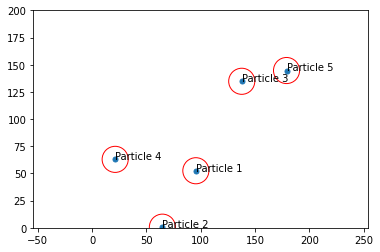

In [37]:
A = df[((df.simulation == "Simulation 1") & (df.time == t0))][["axis", "particle", "time", "position", "velocity"]]
B1 = A[A.axis == "x_1"]
B2 = A[A.axis == "x_2"]
plt.plot(B1.position.values, B2.position.values, "o", ms=5)
#plt.text(x=B1.position.values, y=B2.position.values, s=B1.particle.values)
for i in B1.particle.unique():
    circle = plt.Circle((B1[B1.particle == i].position.values[0], B2[B2.particle == i].position.values[0]), interaction_distance, color='r', fill=False)
    ax = plt.gca()
    ax.add_patch(circle)
    ax.text(B1[B1.particle == i].position.values[0], B2[B2.particle == i].position.values[0], s=i)
    print(i, B1[B1.particle == i].position.values, B2[B2.particle == i].position.values)
plt.axis("equal")
ax.set_xlim([0, box_size_x])
ax.set_ylim([0, box_size_y])
plt.show()
# B1[B1.velocity.abs() <= 1e-1]
# A#.plot()#x="r_1",y="r_2")
#.groupby(["axis"])[["time", "position", "velocity"]].plot(legend=True)

In [38]:
df[((df["particle"].isin(["Particle 2"])) & (df["time"] <= 3 * dt))].sort_values(["particle", "axis"])

,simulation,particle,axis,mass,radius,stopping_time,rest_time,moving_type,timers,time,position,velocity
2,Simulation 1,Particle 2,x_1,1.0,1.0,3.286239,1.061626,1.0,1.356893,0.0000,64.742432,0.000000
12,Simulation 1,Particle 2,x_1,1.0,1.0,3.286239,1.061626,1.0,1.256893,0.1001,64.742432,-4.087819
22,Simulation 1,Particle 2,x_1,1.0,1.0,3.286239,1.061626,1.0,1.156893,0.2002,64.333650,-9.239193
3,Simulation 1,Particle 2,x_2,1.0,1.0,3.173185,1.072075,1.0,1.356893,0.0000,0.575193,0.000000
13,Simulation 1,Particle 2,x_2,1.0,1.0,3.173185,1.072075,1.0,1.256893,0.1001,0.575193,-9.126321
23,Simulation 1,Particle 2,x_2,1.0,1.0,3.173185,1.072075,1.0,1.156893,0.2002,199.662561,-0.555245


In [39]:
import numpy as np
from itertools import combinations

def get_combinations(arr, k):
    return list(combinations(arr, k))

# HoI at time tf (local complex simplexes)
def get_hoi_values(df_ts, order, t0, tf, col="position"):
    m = ((df_ts["time"] >= t0) & (df_ts["time"] <= tf))
    ids = df_ts[m]["particle"].str.replace("Particle ", "").astype(int).unique()
    axis = df_ts[m]["axis"].unique()
    m1 = ((m) & (df_ts["particle"] == df_ts[m]["particle"].unique()[0]) & (df_ts["axis"] == axis[0]))
    size = len(df_ts[m1]["time"].unique())
    combinations = get_combinations(arr=ids, k=order)

    df_final = []
    for ax in axis:
        df = pd.pivot_table(
            df_ts[((m) & (df_ts["axis"] == ax))][["particle", "time", col]],
            values=[col],
            index=["time"],
            columns=["particle"]
        )
    
        df.columns = ["_".join(x).strip("_").replace("Particle ", "") for x in df.columns.to_flat_index()]
        ts = df.values.T

        for c in combinations:
            signs_ = np.zeros(size, dtype="float64")
            values_ = np.ones(size, dtype="float64")
            for k in c:
                values_ *= (ts[k-1] - np.mean(ts[k-1])) / np.std(ts[k-1])
                signs_ += np.sign(values_)
    
            df_aux = pd.DataFrame({
                "t0": np.repeat(str(t0), size),
                "tf": np.repeat(str(tf), size),
                "time": df_ts[m1]["time"].unique(),
                "particles": np.repeat(len(ids), size),
                "order": np.repeat(order, size),
                "column": np.repeat(col, size),
                "axis": np.repeat(ax, size),
                "combination": np.repeat(str(c), size),
                "cofluctuation": values_
            })
    
            # Z score
            df_aux["z_cofluctuation"] = df_aux[["cofluctuation"]].apply(lambda x: (x - np.mean(x)) / np.std(x))
    
            # Coherence rule (1 if it is fully coherent, -1 otherwise)
            # If all the signs are concordant then set the weight sign as positive, otherwise negative
            values_ = df_aux["z_cofluctuation"].values
            exponent = np.sign(order - np.abs(signs_))
            coherence = (-1)**exponent
            df_aux["weight"] = np.where(coherence==1, np.abs(values_), -np.abs(values_))
            
            df_final.append(df_aux)

    df_final = pd.concat(df_final, ignore_index=True)
    return df_final

def create_simplicial_complex(df_ts, t0, tf, t_simplex, col="position", orders=[2, 3]):
    # Estimate HoI for many orders
    df_final = []
    for order in orders:
        df = get_hoi_values(df_ts=df_ts, order=order, t0=t0, tf=tf, col=col)
        df_final.append(df)

    df_final = pd.concat(df_final, ignore_index=True)
    df_final = df_final.sort_values(["time", "axis", "weight", "order"], ascending=[True, True, False, True])
    
    # Fix violations and construct filtration
    
    
    return df_final


In [40]:
# get_hoi_values(df_ts=df, order=2, t0=t0, tf=tf, col="position")
df_ = create_simplicial_complex(df_ts=df, t0=t0, tf=tf, t_simplex=0, col="position", orders=[2, 3])
df_[df_["time"] == 0]

,t0,tf,time,particles,order,column,axis,combination,cofluctuation,z_cofluctuation,weight
8008,0,100.10000000000001,0.0,5,2,position,x_1,"(3, 5)",1.619614,2.422068,2.422068
9009,0,100.10000000000001,0.0,5,2,position,x_1,"(4, 5)",-2.237323,-2.219966,2.219966
27027,0,100.10000000000001,0.0,5,3,position,x_1,"(2, 3, 5)",-0.972418,-1.483039,1.483039
6006,0,100.10000000000001,0.0,5,2,position,x_1,"(2, 5)",-1.017425,-0.934310,0.934310
4004,0,100.10000000000001,0.0,5,2,position,x_1,"(2, 3)",-0.573842,-0.841852,0.841852
24024,0,100.10000000000001,0.0,5,3,position,x_1,"(1, 3, 5)",0.296203,0.428969,0.428969
3003,0,100.10000000000001,0.0,5,2,position,x_1,"(1, 5)",0.309912,0.130747,0.130747
1001,0,100.10000000000001,0.0,5,2,position,x_1,"(1, 3)",0.174795,0.095544,0.095544
20020,0,100.10000000000001,0.0,5,3,position,x_1,"(1, 2, 3)",-0.104947,-0.092477,-0.092477
2002,0,100.10000000000001,0.0,5,2,position,x_1,"(1, 4)",-0.241460,-0.118530,-0.118530


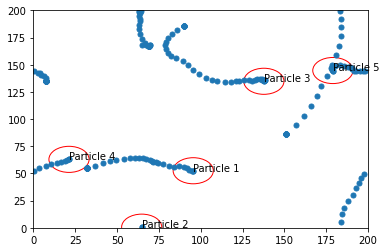

In [45]:
A = df[(
    (df.simulation == "Simulation 1") &
    #(df.particle.isin(["Particle 01", "Particle 03", "Particle 07"])) &
    (df.time <= 40*dt)
)][["axis", "particle", "time", "position", "velocity"]]

B1 = A[A.axis == "x_1"]
B2 = A[A.axis == "x_2"]
plt.plot(B1.position.values, B2.position.values, "o", ms=5)
#plt.text(x=B1.position.values, y=B2.position.values, s=B1.particle.values)
for i in B1.particle.unique():
    circle = plt.Circle((B1[B1.particle == i].position.values[0], B2[B2.particle == i].position.values[0]), interaction_distance, color='r', fill=False)
    ax = plt.gca()
    ax.add_patch(circle)
    ax.text(B1[B1.particle == i].position.values[0], B2[B2.particle == i].position.values[0], s=i)
# plt.axis("equal")
ax.set_xlim([0, box_size_x])
ax.set_ylim([0, box_size_y])
plt.show()

In [46]:
# ef.estimate_pairs_forces(
#     r_i: np.ndarray,
#     r_j: np.ndarray,
#     interaction_distance: float,
#     interaction_strength: float
# )

df_forces = pd.pivot_table(
    df[["particle", "axis", "time", "position"]],
    values=["position"],
    index=["time"],
    columns=["particle", "axis"]
)

df_forces.columns = ["_".join(x).strip("_").replace("Particle ", "") for x in df_forces.columns.to_flat_index()]
df_forces
#df['NewCol'] = df.apply(segmentMatch, args=(df['TimeCol'], df['ResponseCol']), axis=1)



,position_1_x_1,position_1_x_2,position_2_x_1,position_2_x_2,position_3_x_1,position_3_x_2,position_4_x_1,position_4_x_2,position_5_x_1,position_5_x_2
time,,,,,,,,,,
0.0000,95.521996,52.480755,64.742432,0.575193,137.719762,134.764493,21.313656,62.950000,178.928779,144.663809
0.1001,95.521996,52.480755,64.742432,0.575193,137.719762,134.764493,21.313656,62.950000,178.928779,144.663809
0.2002,94.524982,52.557975,64.333650,199.662561,138.084735,135.695511,20.325516,62.796444,178.126022,145.260116
0.3003,92.850827,53.371048,63.409731,199.607036,138.563800,135.633059,18.898621,61.744281,177.913150,146.663911
0.4004,91.656076,55.061715,63.130519,198.787082,138.166941,136.053057,16.546345,60.313079,178.700275,148.065684
...,...,...,...,...,...,...,...,...,...,...
99.6996,126.502184,22.365064,155.985746,149.185371,62.109786,180.199338,152.249358,98.452288,96.171243,9.268335
99.7997,126.502184,22.365064,155.985746,149.185371,62.109786,180.199338,151.432947,102.553358,96.171243,9.268335
99.8998,126.502184,22.365064,155.985746,149.185371,62.109786,180.199338,151.518132,106.221852,96.171243,9.268335
